In [1]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

In [ ]:
data = pd.read_json('tops_fashion.json')

In [ ]:
print ('Number of data points : ', data.shape[0], \
       'Number of features/variables:', data.shape[1])

In [ ]:
data.columns

### we are choosing seven features out of 19 features in dataset

1. asin  ( Amazon standard identification number)
2. brand ( brand to which the product belongs to )
3. color ( Color information of apparel, it can contain many colors as   a value ex: red and black stripes ) 
4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT )
5. medium_image_url  ( url of the image )
6. title (title of the product.)
7. formatted_price (price of the product)

In [ ]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [ ]:
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])
data.head()


### 1 Data Cleaning
### 1.0 missing data 

1.1)product_type_name

In [ ]:
print(data['product_type_name'].describe())

In [ ]:
print(data['product_type_name'].unique())

In [ ]:
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

1.2)brand

In [ ]:
print(data['brand'].describe())

In [ ]:
print(data['brand'].unique())

In [ ]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

1.3)color

In [ ]:
print(data['color'].describe())

In [ ]:
print(data['color'].unique())

In [ ]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

1.4)formatted_price

In [ ]:
print(data['formatted_price'].describe())

In [ ]:
formatted_price_count = Counter(list(data['formatted_price']))
formatted_price_count.most_common(10)

1.5)title

In [ ]:
print(data['title'].describe())

In [ ]:
title_count = Counter(list(data['title']))
title_count.most_common(10)

### 1.1 reducing data 

In [ ]:
data.to_pickle('pickels/180k_apparel_data')

In [ ]:
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

In [ ]:
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

In [ ]:
data.to_pickle('pickels/28k_apparel_data')

### 1.2 remove duplicates 

In [ ]:
data = pd.read_pickle('pickels/28k_apparel_data')
print(sum(data.duplicated('title')))

In [ ]:
data.head()

In [ ]:
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

In [ ]:
data_sorted.sort_values('title',inplace=True,ascending=False)
data_sorted.head()

In [ ]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)


In [ ]:
import itertools
stage1_dedupe_asins = []
i=0
j=0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    previous_i = i 
    a = data['title'].loc[indices[i]].split()
    j = i+1
    while j < num_data_points:
        b = data['title'].loc[indices[j]].split()
        length = max(len(a),len(b))
        count = 0
        for k in itertools.zip_longest(a,b):
            if(k[0] == k[1]):
                count += 1 
            if(length-count)>2:
                stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])
                i=j
            else:
                j+=1
        if previous_i == i:
            break
            
                    
            

In [ ]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

In [ ]:
print('Number of data points : ', data.shape[0])
data.to_pickle('pickels/17k_apperal_data')

In [ ]:
data = pd.read_pickle('pickels/17k_apperal_data')

In [ ]:
indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []

In [ ]:
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    a = data['title'].loc[i].split()
    for j in indices:
        b = data['title'].loc[j].split()
        length = max(len(a),len(b))
        count  = 0
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1
        if (length - count) < 3:
            indices.remove(j)

In [ ]:
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]
print('Number of data points after stage two of dedupe: ',data.shape[0])

In [ ]:
data.to_pickle('pickels/16k_apperal_data')

### 2 Text pre-processing

In [3]:
data = pd.read_pickle('pickels/16k_apperal_data')

In [5]:
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

list of stop words: {'which', "you'll", 'while', 'whom', 'be', 'other', 'its', 'isn', 'during', 'by', 'having', 'wasn', 'between', 'below', 'where', 'shouldn', 'these', 'hers', 'before', 'mightn', 'had', 'those', 'over', 'did', 'can', "won't", 'yourselves', "shan't", "wasn't", 'are', "aren't", "weren't", 'too', 'that', 'y', 'than', 'no', 'to', 'him', 'ain', 'same', 'ourselves', 'when', 'herself', 'm', 'have', 'has', 'this', 'she', 'both', 'am', 'myself', 'll', 'his', 'why', 'few', 'do', 'but', 'after', 'mustn', 'then', 'they', 'there', 'on', 'how', 'her', 'being', 'ma', 'been', 'for', "shouldn't", 'won', 'me', 've', 's', "mightn't", 'your', 'until', 'more', 'the', 'd', 'now', 'each', 'again', 'into', 'yourself', 'such', 'some', 'further', 'their', 'himself', 'most', "don't", 'needn', 'from', 'we', 'my', "isn't", 'off', 'what', 'an', 're', 'at', 'because', 'itself', 'it', 'were', 'is', 'down', 'or', 'you', 'as', 'hasn', 'above', 'ours', 'not', 'only', 'i', 'shan', 'out', 'them', 'weren'

In [6]:
def nlp_preprocessing(total_text,index,column):
    if type(total_text) is not int:
        string = ""
        for words in total_text_split():
            word = ("".join(e for e in words if e.isalnum()))
            word = word.lower()
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

### Stemming


In [1]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
print(stemmer.stem('arguing'))
print(stemmer.stem('fishing'))


# We tried using stemming on our titles and it didnot work very well. 


argu
fish


### 3 Text based product similarity 

In [2]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [3]:
def display_img(url,ax,fig):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)

In [4]:
def plot_heatmap(keys,values,labels,url,text):
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
    fig = plt.figure(figsize=(25,3))
    ax = plt.subplot(gs[0])
    ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
    ax.set_xticklabels(keys)
    ax.set_title(text)
    ax = plt.subplot(gs[1])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    plt.show()



In [5]:
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):
    intersection = set(vec1.keys()) & set(vec2.keys()) 
    for i in vec2:
        if i not in intersection:
            vec2[i]=0
    keys = list(vec2.keys())
    values = [vec2[x] for x in vec2.keys()]
    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)

In [6]:
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words)

In [7]:
def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)
    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

### 3.1 Bag of words on product titles 

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer  = CountVectorizer()
title_features = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()

(16042, 12609)

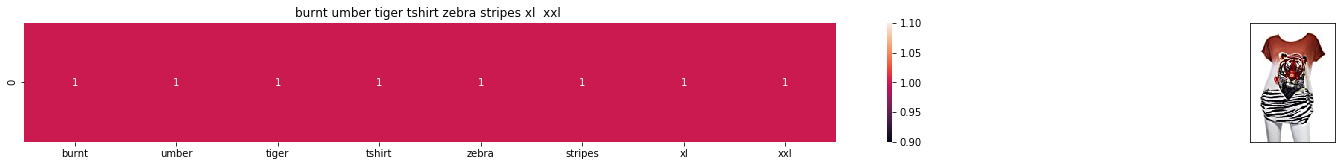

ASIN : B00JXQB5FQ
Brand: Si Row
Title: burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 0.0


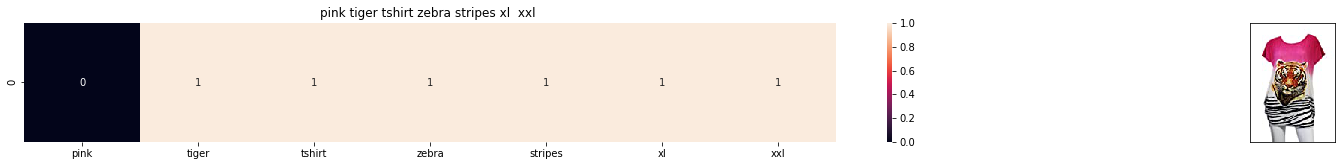

ASIN : B00JXQASS6
Brand: Si Row
Title: pink tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 1.7320508075688772


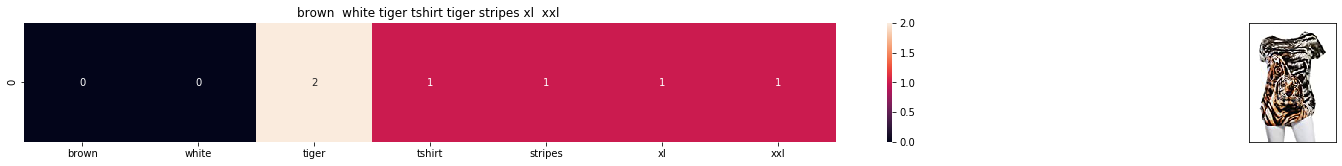

ASIN : B00JXQCWTO
Brand: Si Row
Title: brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean similarity with the query image : 2.449489742783178


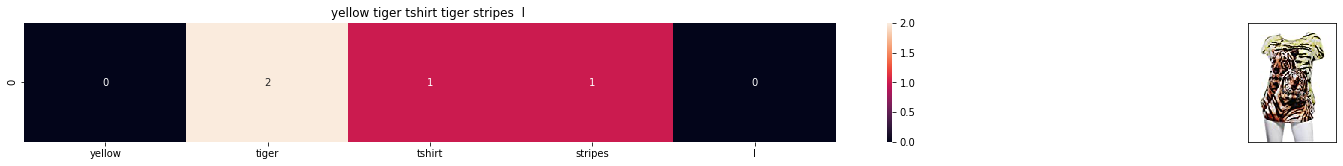

ASIN : B00JXQCUIC
Brand: Si Row
Title: yellow tiger tshirt tiger stripes  l 
Euclidean similarity with the query image : 2.6457513110645907


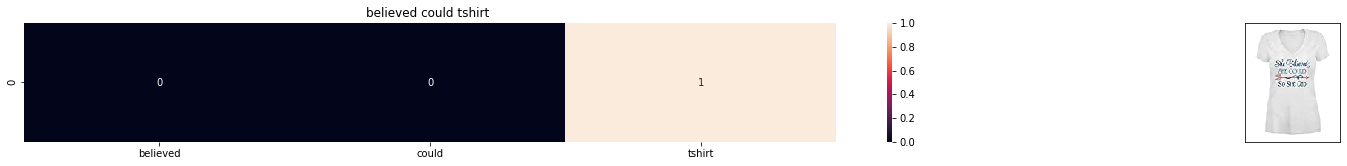

ASIN : B07568NZX4
Brand: Rustic Grace
Title: believed could tshirt 
Euclidean similarity with the query image : 3.0


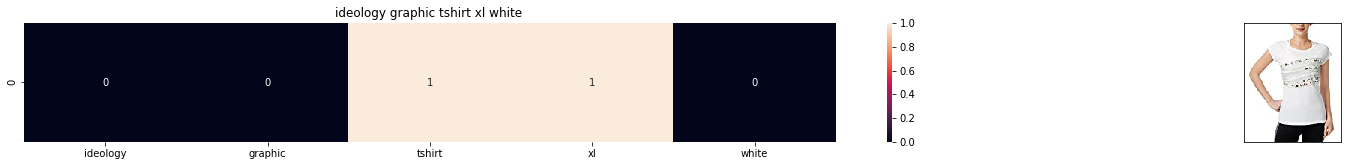

ASIN : B01NB0NKRO
Brand: Ideology
Title: ideology graphic tshirt xl white 
Euclidean similarity with the query image : 3.0


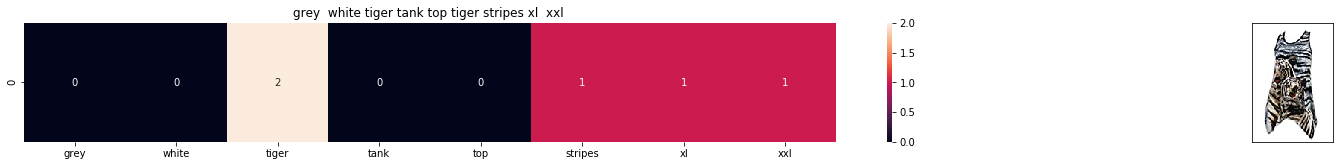

ASIN : B00JXQAFZ2
Brand: Si Row
Title: grey  white tiger tank top tiger stripes xl  xxl 
Euclidean similarity with the query image : 3.0


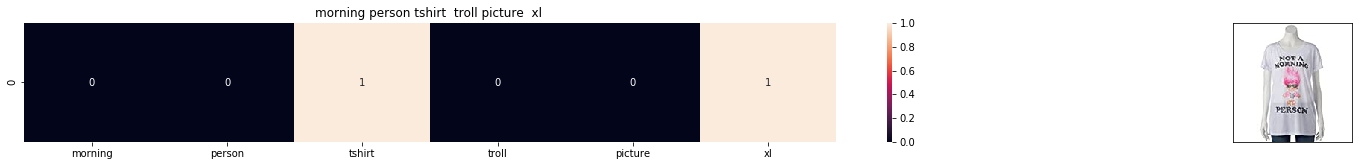

ASIN : B01CLS8LMW
Brand: Awake
Title: morning person tshirt  troll picture  xl 
Euclidean similarity with the query image : 3.1622776601683795


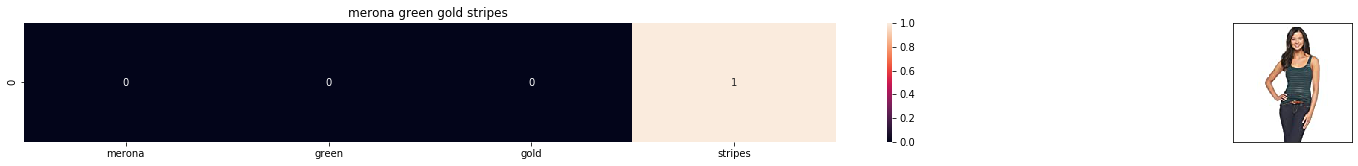

ASIN : B01KVZUB6G
Brand: Merona
Title: merona green gold stripes 
Euclidean similarity with the query image : 3.1622776601683795


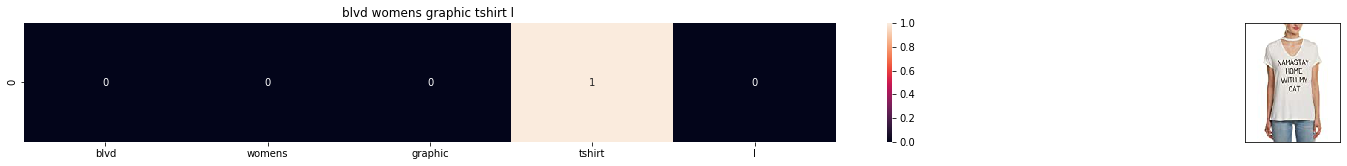

ASIN : B0733R2CJK
Brand: BLVD
Title: blvd womens graphic tshirt l 
Euclidean similarity with the query image : 3.1622776601683795


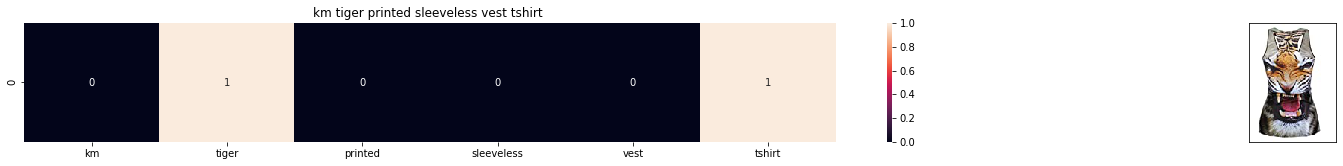

ASIN : B012VQLT6Y
Brand: KM T-shirt
Title: km tiger printed sleeveless vest tshirt 
Euclidean similarity with the query image : 3.1622776601683795


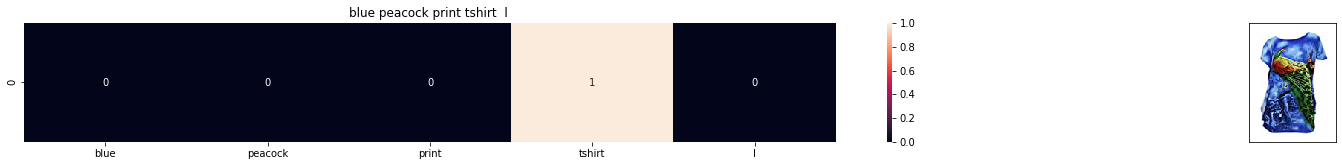

ASIN : B00JXQC8L6
Brand: Si Row
Title: blue peacock print tshirt  l 
Euclidean similarity with the query image : 3.1622776601683795


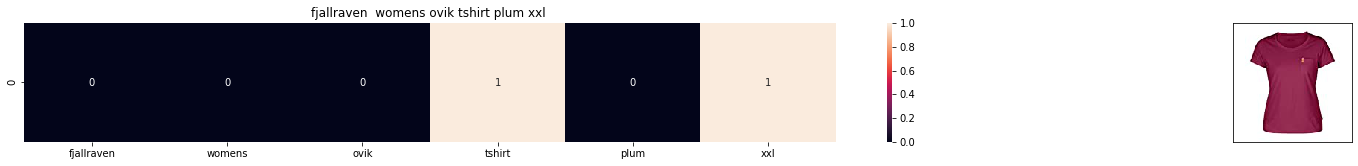

ASIN : B06XC3CZF6
Brand: Fjallraven
Title: fjallraven  womens ovik tshirt plum xxl 
Euclidean similarity with the query image : 3.1622776601683795


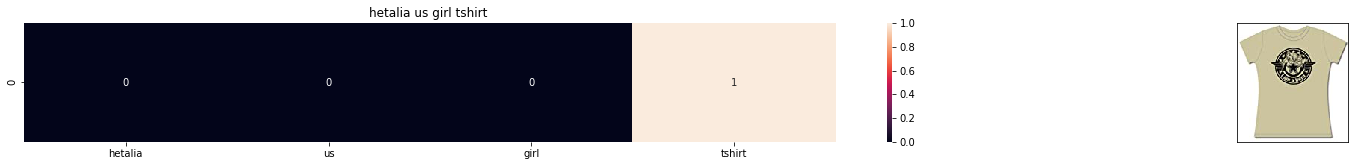

ASIN : B005IT8OBA
Brand: Hetalia
Title: hetalia us girl tshirt 
Euclidean similarity with the query image : 3.1622776601683795


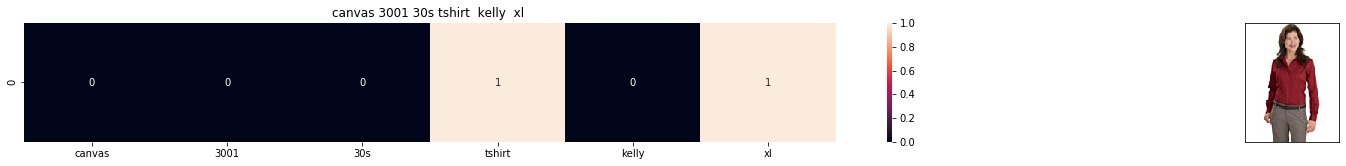

ASIN : B0088PN0LA
Brand: Red House
Title: canvas 3001 30s tshirt  kelly  xl 
Euclidean similarity with the query image : 3.1622776601683795


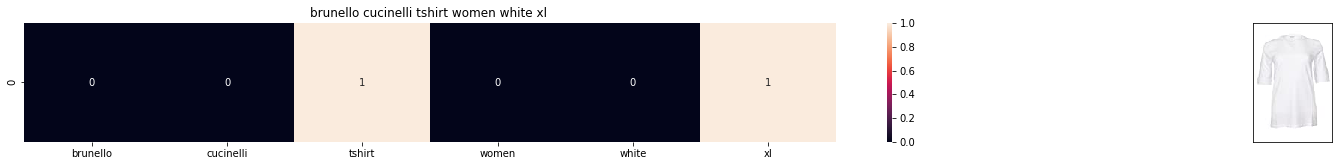

ASIN : B06X99V6WC
Brand: Brunello Cucinelli
Title: brunello cucinelli tshirt women white xl 
Euclidean similarity with the query image : 3.1622776601683795


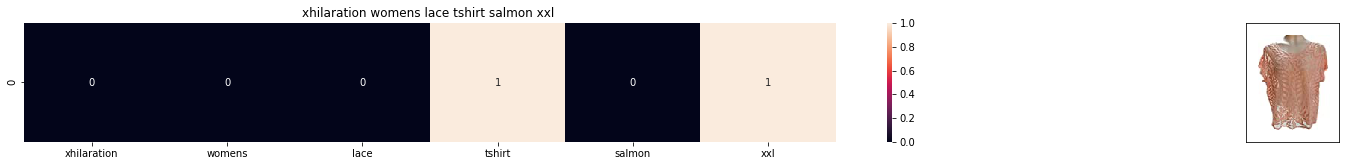

ASIN : B06Y1JPW1Q
Brand: Xhilaration
Title: xhilaration womens lace tshirt salmon xxl 
Euclidean similarity with the query image : 3.1622776601683795


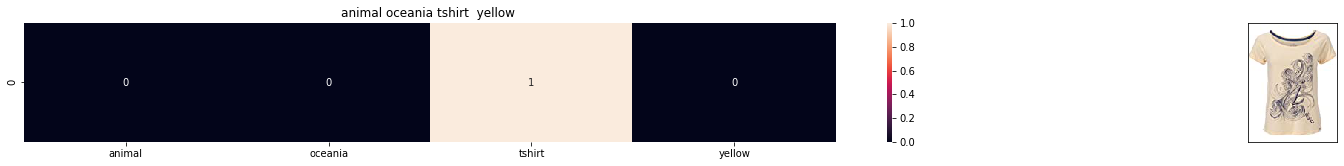

ASIN : B06X6GX6WG
Brand: Animal
Title: animal oceania tshirt  yellow 
Euclidean similarity with the query image : 3.1622776601683795


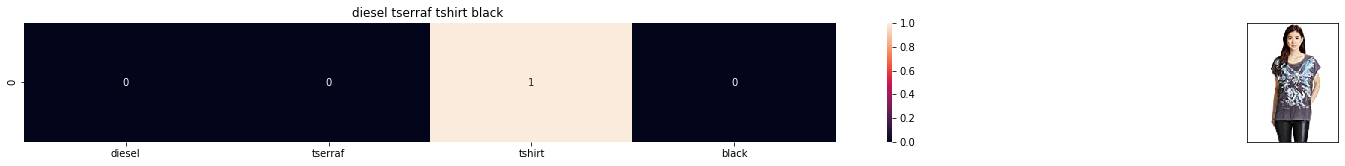

ASIN : B017X8PW9U
Brand: Diesel
Title: diesel tserraf tshirt black 
Euclidean similarity with the query image : 3.1622776601683795


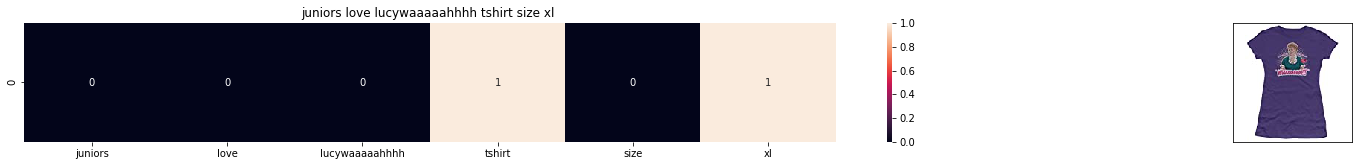

ASIN : B00IAA4JIQ
Brand: I Love Lucy
Title: juniors love lucywaaaaahhhh tshirt size xl 
Euclidean similarity with the query image : 3.1622776601683795


In [10]:
def bag_of_words_model(doc_id,num_results):
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])
    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)
    
bag_of_words_model(12566, 20)

### 3.2 tf-idf based product similarity 

In [11]:
tfidf_title_vectorizer = TfidfVectorizer(min_df=0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

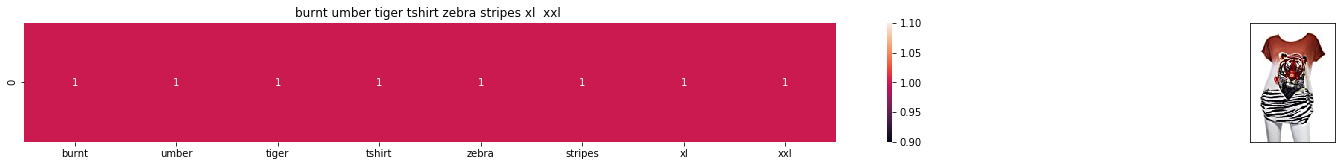

ASIN : B00JXQB5FQ
Brand: Si Row
Title: burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 0.0


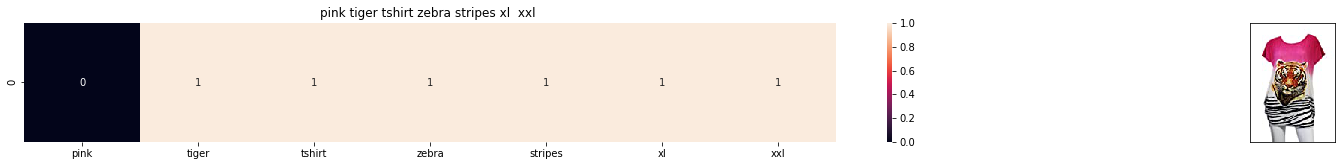

ASIN : B00JXQASS6
Brand: Si Row
Title: pink tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 0.7536331912451363


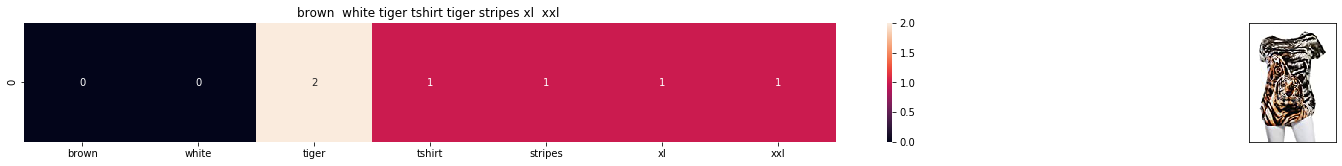

ASIN : B00JXQCWTO
Brand: Si Row
Title: brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean similarity with the query image : 0.9357643943769647


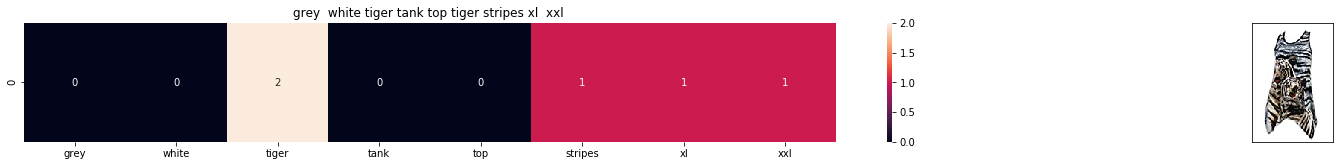

ASIN : B00JXQAFZ2
Brand: Si Row
Title: grey  white tiger tank top tiger stripes xl  xxl 
Euclidean similarity with the query image : 0.9586153524200749


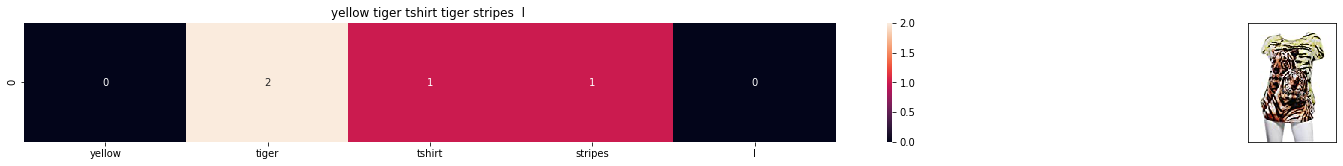

ASIN : B00JXQCUIC
Brand: Si Row
Title: yellow tiger tshirt tiger stripes  l 
Euclidean similarity with the query image : 1.000074961446881


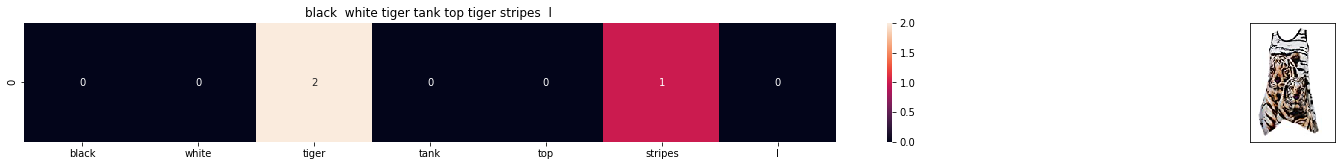

ASIN : B00JXQAO94
Brand: Si Row
Title: black  white tiger tank top tiger stripes  l 
Euclidean similarity with the query image : 1.023215552457452


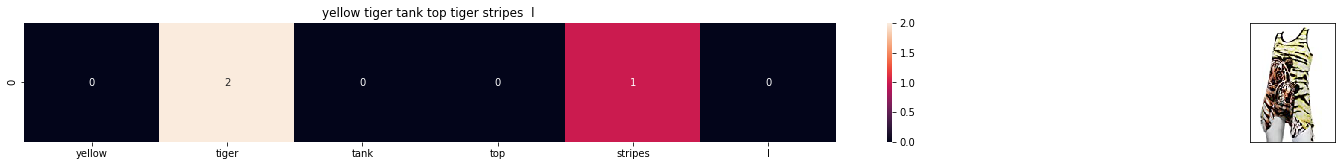

ASIN : B00JXQAUWA
Brand: Si Row
Title: yellow tiger tank top tiger stripes  l 
Euclidean similarity with the query image : 1.031991846303421


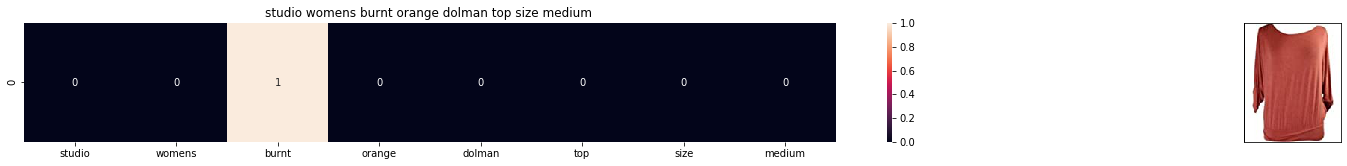

ASIN : B06XSCVFT5
Brand: Studio M
Title: studio womens burnt orange dolman top size medium 
Euclidean similarity with the query image : 1.2106843670424716


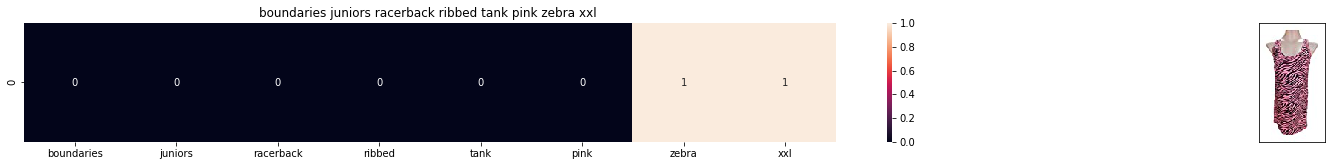

ASIN : B06Y2GTYPM
Brand: No Boundaries
Title: boundaries juniors racerback ribbed tank pink zebra xxl 
Euclidean similarity with the query image : 1.2121683810720831


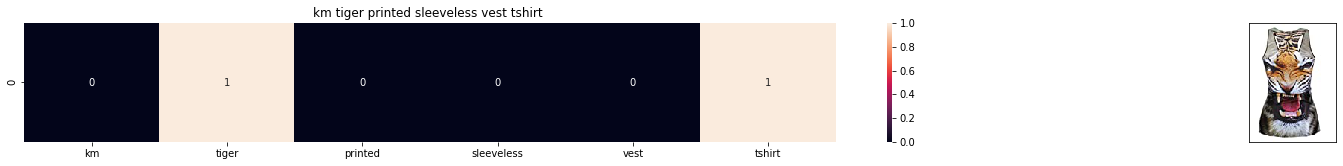

ASIN : B012VQLT6Y
Brand: KM T-shirt
Title: km tiger printed sleeveless vest tshirt 
Euclidean similarity with the query image : 1.219790640280982


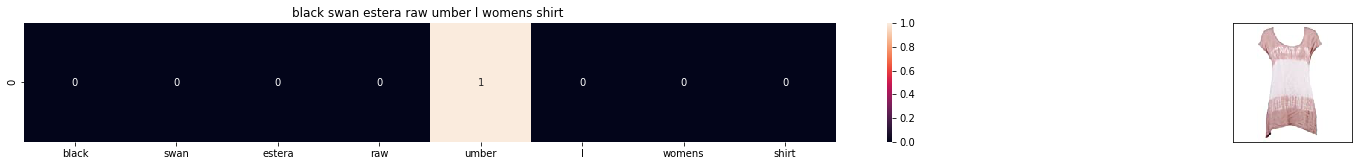

ASIN : B06Y1VN8WQ
Brand: Black Swan
Title: black swan estera raw umber l womens shirt 
Euclidean similarity with the query image : 1.2206849659998316


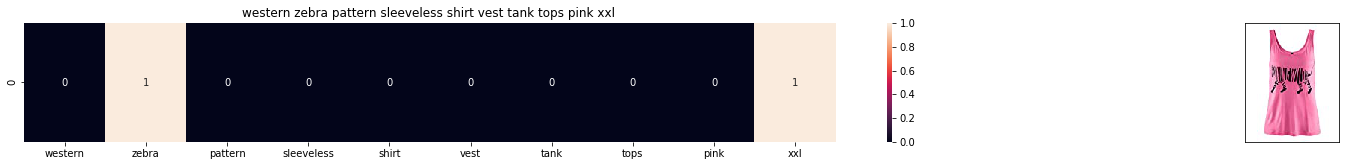

ASIN : B00Z6HEXWI
Brand: Black Temptation
Title: western zebra pattern sleeveless shirt vest tank tops pink xxl 
Euclidean similarity with the query image : 1.221281392120943


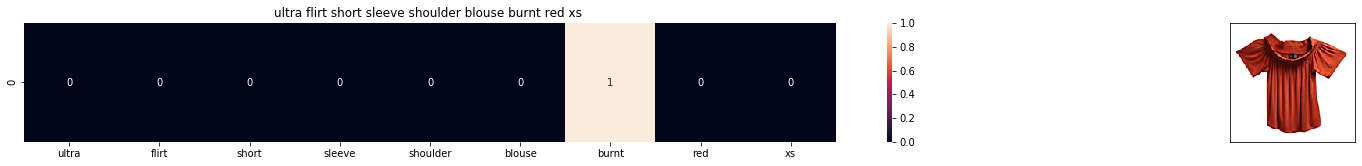

ASIN : B074TR12BH
Brand: Ultra Flirt
Title: ultra flirt short sleeve shoulder blouse burnt red xs 
Euclidean similarity with the query image : 1.2313364094597743


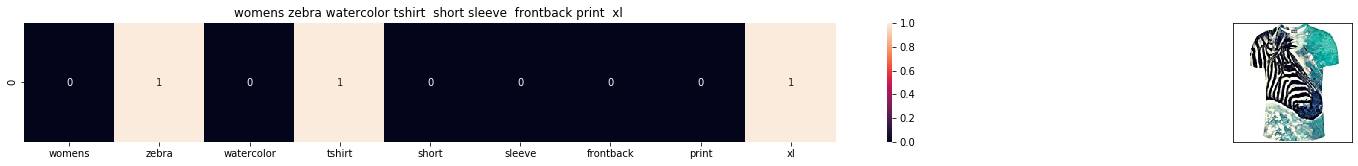

ASIN : B072R2JXKW
Brand: WHAT ON EARTH
Title: womens zebra watercolor tshirt  short sleeve  frontback print  xl 
Euclidean similarity with the query image : 1.2318451972624516


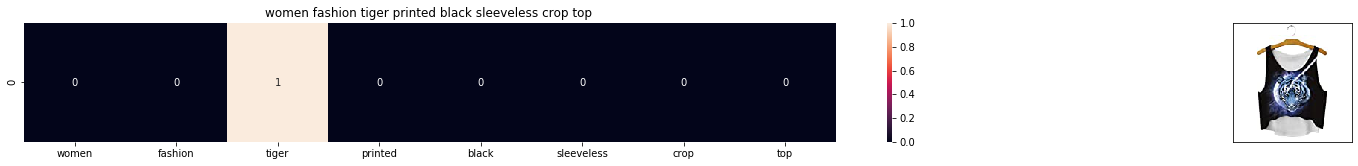

ASIN : B074T8ZYGX
Brand: MKP Crop Top
Title: women fashion tiger printed black sleeveless crop top 
Euclidean similarity with the query image : 1.2340607457359425


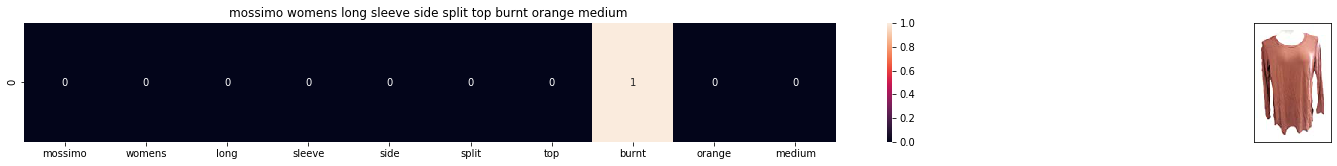

ASIN : B071ZDF6T2
Brand: Mossimo
Title: mossimo womens long sleeve side split top burnt orange medium 
Euclidean similarity with the query image : 1.2352785577664824


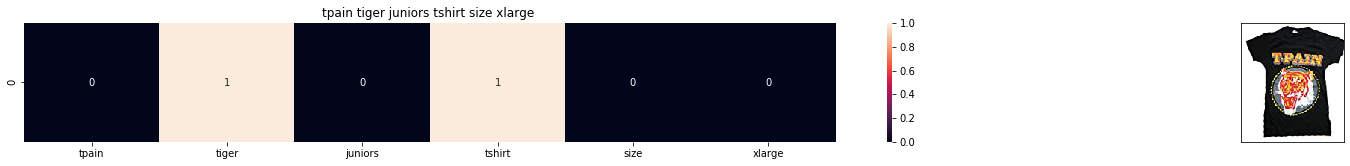

ASIN : B01K0H02OG
Brand: Tultex
Title: tpain tiger juniors tshirt size xlarge 
Euclidean similarity with the query image : 1.236457298812782


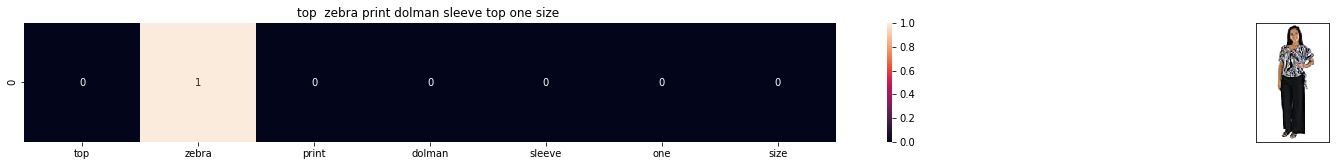

ASIN : B00H8A6ZLI
Brand: Vivian's Fashions
Title: top  zebra print dolman sleeve top one size 
Euclidean similarity with the query image : 1.24996155052848


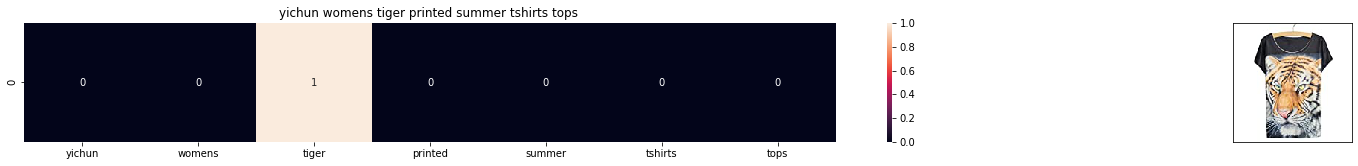

ASIN : B010NN9RXO
Brand: YICHUN
Title: yichun womens tiger printed summer tshirts tops 
Euclidean similarity with the query image : 1.2535461420856102


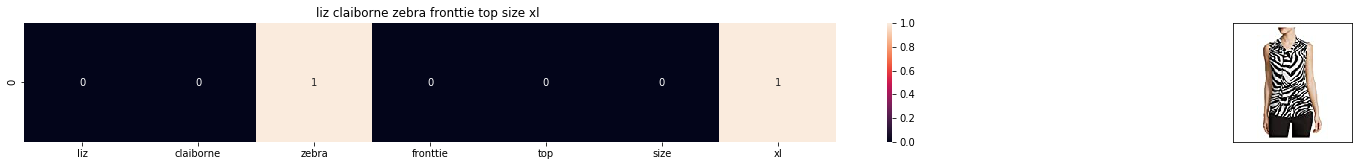

ASIN : B06XBY5QXL
Brand: Liz Claiborne
Title: liz claiborne zebra fronttie top size xl 
Euclidean similarity with the query image : 1.2538832938357722


In [12]:
def tfidf_model(doc_id,num_results):
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])
    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)
    
tfidf_model(12566, 20)

### 3.3 idf based product similarity  

In [13]:
idf_title_vectorizer = TfidfVectorizer(min_df=0)
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

In [14]:
def n_containing(word):
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    return math.log(data.shape[0]/(n_containing(word)))

In [16]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    idf_val = idf(i)
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val
        

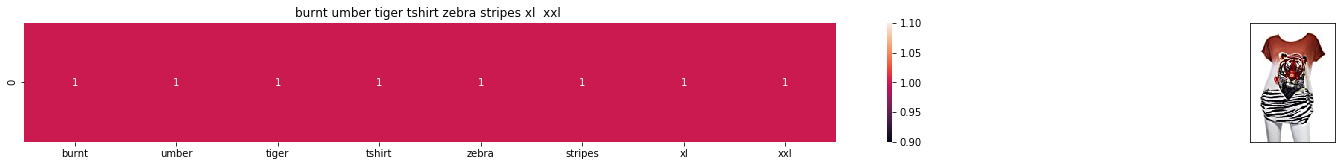

ASIN : B00JXQB5FQ
Brand: Si Row
Title: burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 0.0


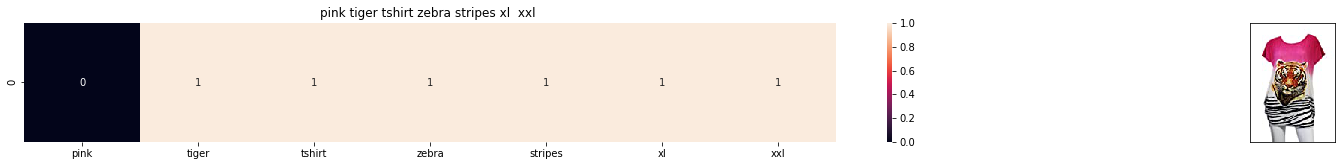

ASIN : B00JXQASS6
Brand: Si Row
Title: pink tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 12.205071311221767


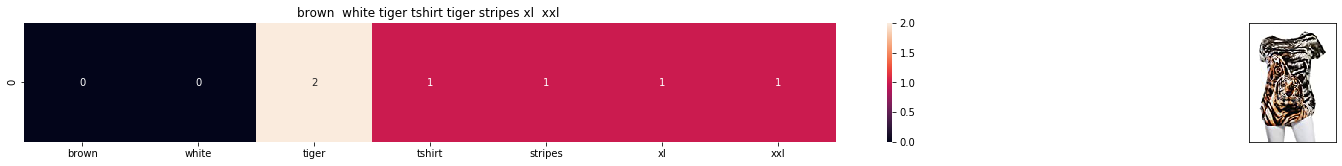

ASIN : B00JXQCWTO
Brand: Si Row
Title: brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean similarity with the query image : 14.468362685603465


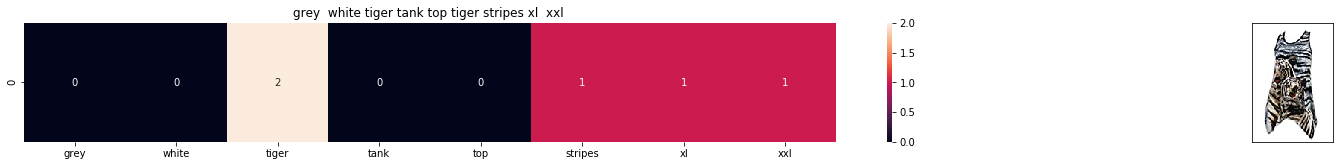

ASIN : B00JXQAFZ2
Brand: Si Row
Title: grey  white tiger tank top tiger stripes xl  xxl 
Euclidean similarity with the query image : 14.486832924778964


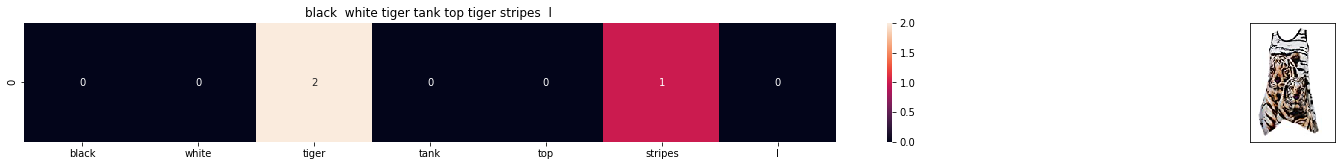

ASIN : B00JXQAO94
Brand: Si Row
Title: black  white tiger tank top tiger stripes  l 
Euclidean similarity with the query image : 14.833392966672909


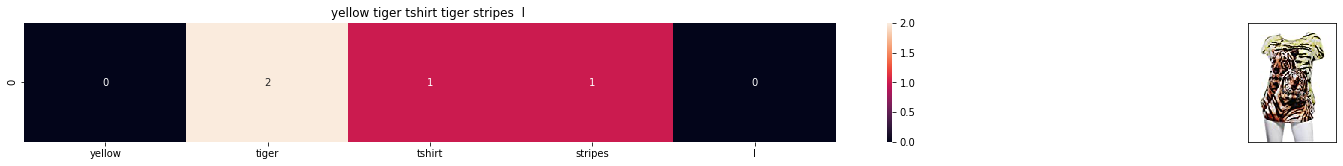

ASIN : B00JXQCUIC
Brand: Si Row
Title: yellow tiger tshirt tiger stripes  l 
Euclidean similarity with the query image : 14.898744516719225


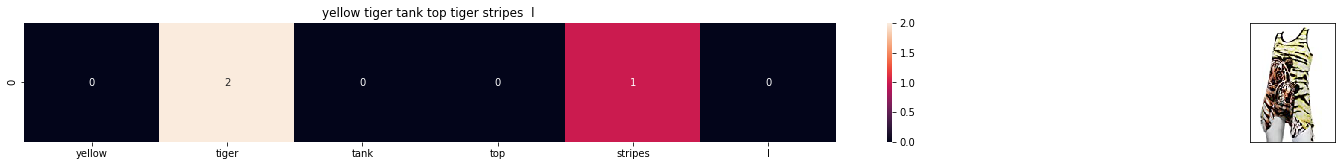

ASIN : B00JXQAUWA
Brand: Si Row
Title: yellow tiger tank top tiger stripes  l 
Euclidean similarity with the query image : 15.22445828734377


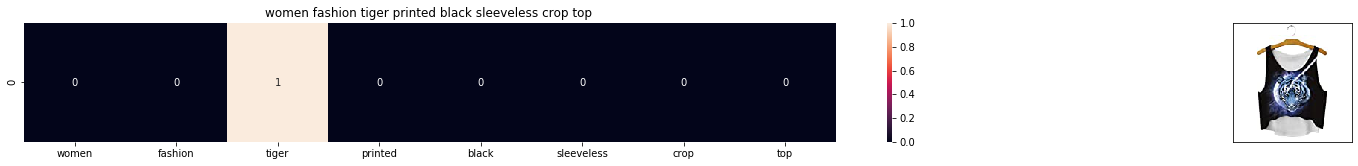

ASIN : B074T8ZYGX
Brand: MKP Crop Top
Title: women fashion tiger printed black sleeveless crop top 
Euclidean similarity with the query image : 17.080812955631995


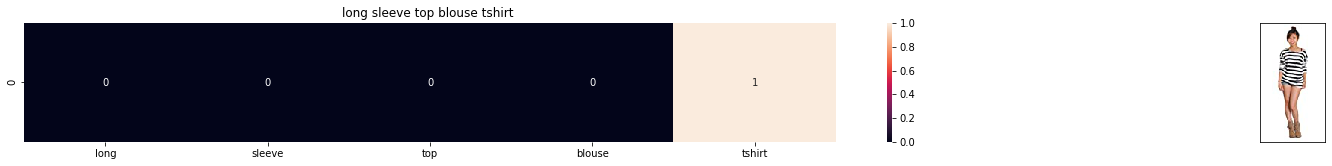

ASIN : B00KF2N5PU
Brand: Vietsbay
Title: long sleeve top blouse tshirt 
Euclidean similarity with the query image : 17.090168125645416


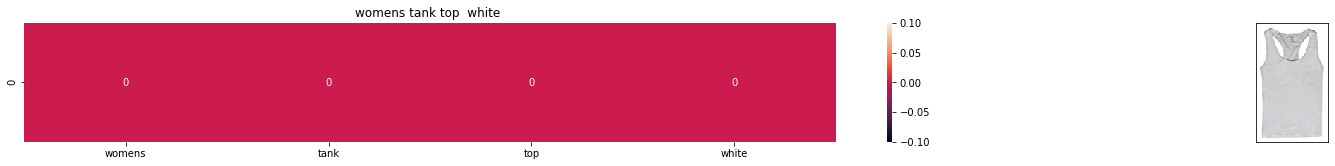

ASIN : B00JPOZ9GM
Brand: Sofra
Title: womens tank top  white 
Euclidean similarity with the query image : 17.153215337562703


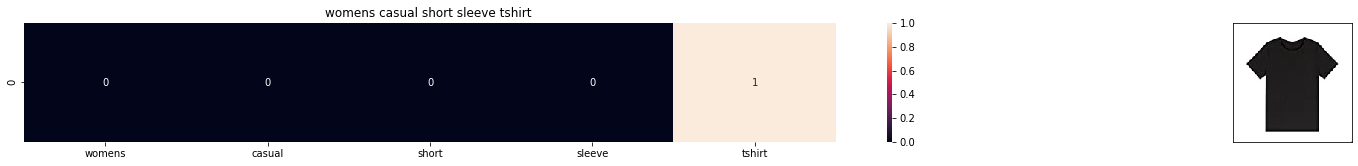

ASIN : B074T9KG9Q
Brand: Rain
Title: womens casual short sleeve tshirt 
Euclidean similarity with the query image : 17.33671523874989


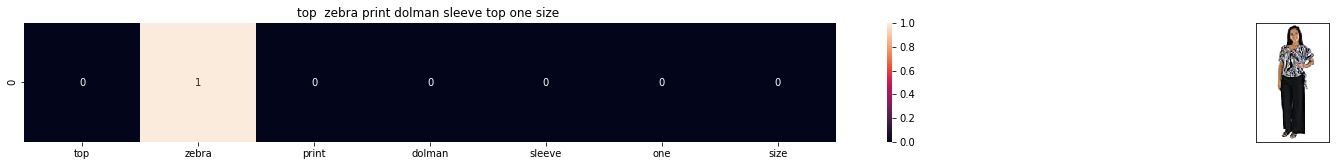

ASIN : B00H8A6ZLI
Brand: Vivian's Fashions
Title: top  zebra print dolman sleeve top one size 
Euclidean similarity with the query image : 17.410075941001253


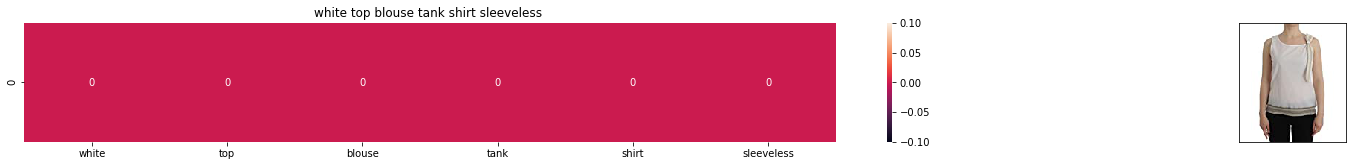

ASIN : B074G5G5RK
Brand: ERMANNO SCERVINO
Title: white top blouse tank shirt sleeveless 
Euclidean similarity with the query image : 17.539921335459557


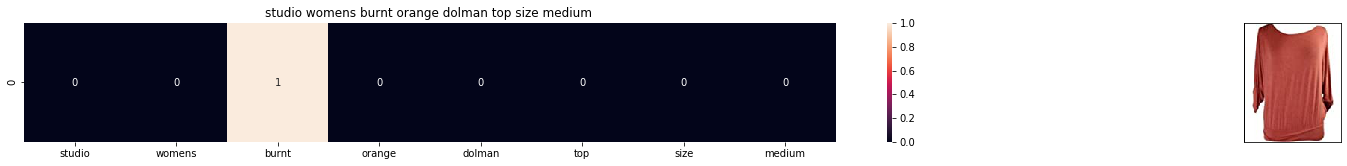

ASIN : B06XSCVFT5
Brand: Studio M
Title: studio womens burnt orange dolman top size medium 
Euclidean similarity with the query image : 17.61275854366134


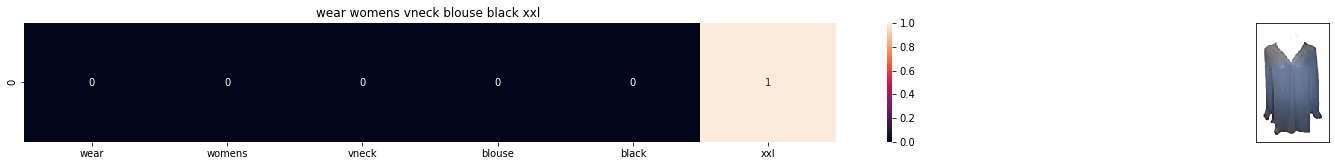

ASIN : B06Y6FH453
Brand: Who What Wear
Title: wear womens vneck blouse black xxl 
Euclidean similarity with the query image : 17.623745282500135


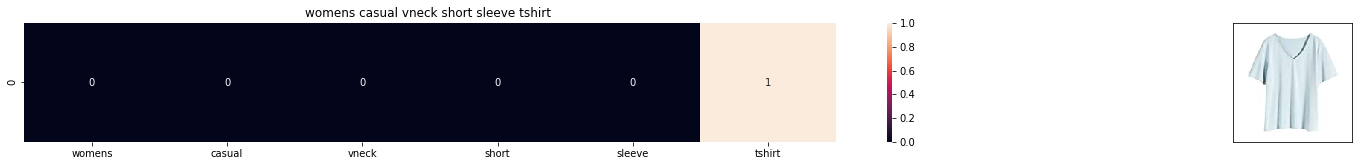

ASIN : B074V45DCX
Brand: Rain
Title: womens casual vneck short sleeve tshirt 
Euclidean similarity with the query image : 17.634342496835046


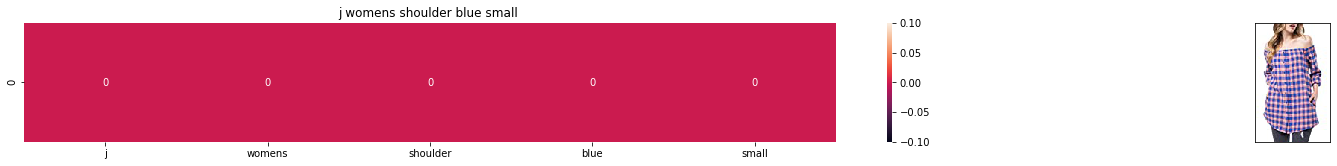

ASIN : B07583CQFT
Brand: Very J
Title: j womens shoulder blue small 
Euclidean similarity with the query image : 17.63753712743611


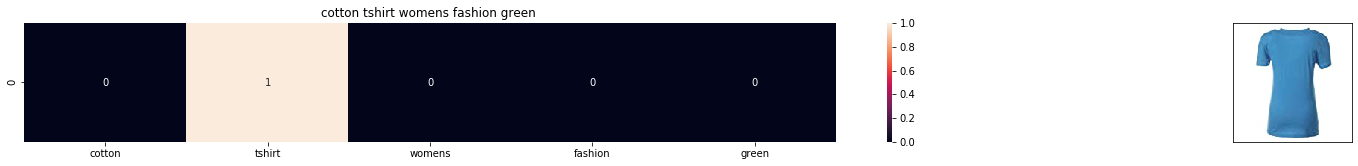

ASIN : B073GJGVBN
Brand: Ivan Levi
Title: cotton tshirt womens fashion green 
Euclidean similarity with the query image : 17.7230738913371


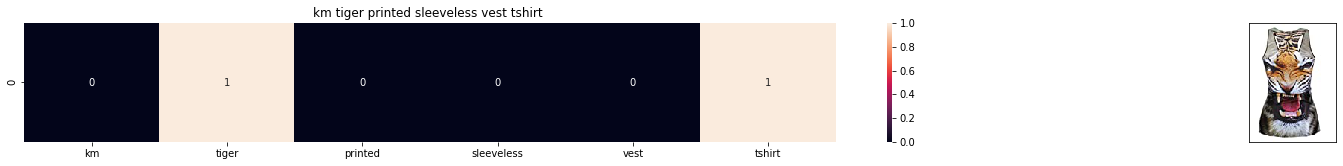

ASIN : B012VQLT6Y
Brand: KM T-shirt
Title: km tiger printed sleeveless vest tshirt 
Euclidean similarity with the query image : 17.762588561202364


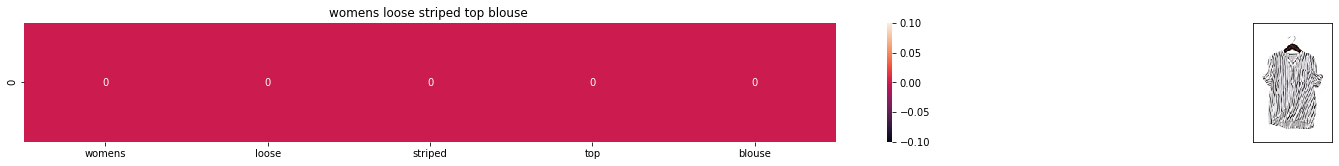

ASIN : B00ZZMYBRG
Brand: HP-LEISURE
Title: womens loose striped top blouse 
Euclidean similarity with the query image : 17.779536864674238


In [17]:
def idf_model(doc_id,num_results):
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])
    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*125)
    
idf_model(12566, 20)